In [10]:
from quant_rotor.core.sparse.hamiltonian import hamiltonian_sparse
from quant_rotor.core.sparse.hamiltonian_big import hamiltonian_general_sparse, hamiltonian_big_sparse
from quant_rotor.core.dense.de_solve_one_thermal import integration_scheme
import numpy as np
from quant_rotor.models.sparse.support_ham import build_V_in_p
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from quant_rotor.models.dense.stat_mech_thermo import generate_graphs, A, Z, S, heat_capacity, beta_func
from quant_rotor.models.dense.stat_mech_thermo import U as U_stat
import quant_rotor.models.dense.thermofield_boltz_funcs as bz
import opt_einsum as oe
import scipy as sp
from itertools import permutations

# One body hamiltonian.

In [167]:
site = 3
state = 3
g = 0
K, V = build_V_in_p(state)
K, V = K.toarray(), V.toarray()

# V.transpose(0, 2, 1, 3).reshape((states**2, states**2))

In [168]:
U, K_prim_new = bz.thermofield_change_of_basis(K)

In [ ]:
d_pq = np.eye(state)

V_tensor = V.reshape(state, state, state, state)

I = np.eye(state)
V_prim = oe.contract('pqrs,mw,nv->pmqnrwsv', V_tensor, I, I,  optimize='optimal')

V_grouped = V_prim.reshape(state**2, state**2, state**2, state**2)

V_tilda = oe.contract('Mi,Wj,ijab,aN,bV->MWNV', U, U, V_grouped, U, U, optimize='optimal')

In [170]:
# K_prim_new

In [171]:
K_tilda_new = bz.H_tilde_maker(K)

In [172]:
K_tilda_old = bz.depr_H_tilde_maker(K)

[1. 1.]


In [173]:
K_tilda_new

array([[ 0.666666666667, -0.            ,  0.471404520791,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ],
       [-0.            ,  1.            , -0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ],
       [ 0.471404520791, -0.            ,  0.333333333333,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ],
       [ 0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ],
       [ 0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  0.            ],
       [ 0.            ,  0.            ,  0.            ,  0.            ,  0.            ,  1.            ,  0.            ,  0.            ,  0.            ],
       [ 0.            ,  0.

In [174]:
# K_tilda_old

In [175]:
col_permute = np.array([0 ,1, 2, 5, 6, 4, 7 ,3, 8])
row_permute = np.array([0 ,1, 2, 5, 6, 4, 7 ,3, 8])

K_tilda_new_perm = K_tilda_new[np.ix_(row_permute, col_permute)]

In [176]:
# K_tilda_new_perm

In [177]:
np.array_equal(np.abs(K_tilda_old), np.abs(K_tilda_new_perm))

False

In [178]:
# Boolean array of mismatches
mask = np.abs(K_tilda_old) != np.abs(K_tilda_new_perm)

# Get indices where values differ
diff_indices = np.argwhere(mask)

# Print mismatches
for i, j in diff_indices:
    print(f"Mismatch at ({i}, {j}): Old = {np.abs(K_tilda_old)[i, j]}, New_perm = {np.abs(K_tilda_new_perm)[i, j]}")

Mismatch at (2, 1): Old = 0.0, New_perm = 8.255428088526173e-18


In [179]:
H = hamiltonian_general_sparse(state, site, g)[0].toarray()

eig_val_ED, _ = np.linalg.eigh(H)

In [180]:
beta, si5_st5_dB_var, si5_st5_sol_var, _  = integration_scheme(site, state, g, t_init=0,t_final=10,nof_points=100000, import_K_V_TF=True, K_import=K_tilda_new_perm, V_import=V_tilda)
beta_new, si5_st5_dB_var, si5_st5_sol_var_new, _  = integration_scheme(site, state, g, t_init=0,t_final=10,nof_points=100000, import_K_V_TF=True, K_import=K_tilda_new, V_import=V_tilda)
beta_old, si5_st5_dB_var, si5_st5_sol_var_old, _  = integration_scheme(site, state, g, t_init=0,t_final=10,nof_points=100000, import_K_V_TF=True, K_import=K_tilda_old, V_import=V_tilda)

si5_st5_ED_Z_val = np.array([np.log(Z(eig_val_ED, x)) for x in beta])

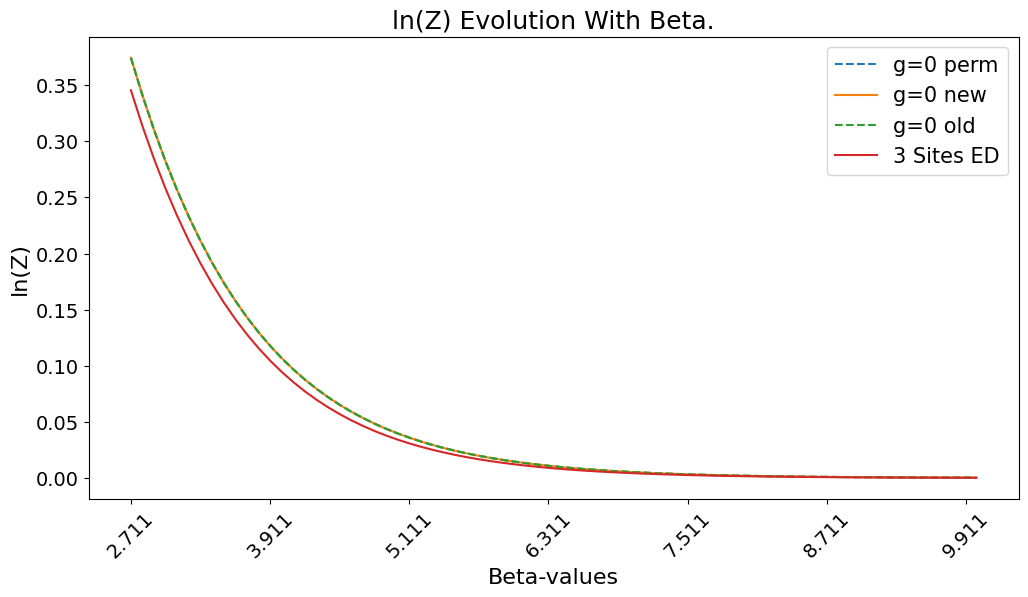

In [ ]:
n = 30
plt.figure(figsize=(12, 6))
plt.plot(beta[n:], (si5_st5_sol_var + np.log(state**site))[n:], label=f"g={0} perm", linestyle='--')
plt.plot(beta_new[n:], (si5_st5_sol_var_new + np.log(state**site))[n:], label=f"g={0} new", linestyle='-')
plt.plot(beta_old[n:], (si5_st5_sol_var_old + np.log(state**site))[n:], label=f"g={0} old", linestyle='--')
plt.plot(beta[n:], si5_st5_ED_Z_val[n:], label=f"{site} Sites ED")
plt.xticks(beta[n:][::12], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("ln(Z)")
plt.title("ln(Z) Evolution With Beta.", fontsize=18)
plt.legend()
plt.show()

In [ ]:
V_tilda = (np.kron(U, U).T @ V_prim @ np.kron(U, U))

In [ ]:
eig_val_K, eig_vac_K = np.linalg.eigh(K)
eig_val_K_tilda_new, _ = np.linalg.eigh(K_tilda_new)
eig_val_K_tilda_old, _ = np.linalg.eigh(K_tilda_old)

print("K:", np.sort(eig_val_K))
print("K_tilda:", np.sort(eig_val_K_tilda_new))
print("K_tilda:", np.sort(eig_val_K_tilda_old))

In [ ]:
eig_val_V, eig_vac_V = np.linalg.eigh(V)
eig_val_V_tilda, eig_vac_V_tilda = np.linalg.eigh(V_tilda)

print("V:", np.sort(eig_val_V))
print("V_tilda:", np.sort(eig_val_V_tilda))

In [ ]:
time,t_0, one_max_TDCC, dTa_idt_sol = integration_scheme(site, state, 1, t_init=0,t_final=100,nof_points=1000000, import_K_V_TF=True, K_import=K_tilda_new, V_import=V_tilda)

In [ ]:
plt.plot(time, t_0, label=f"g = {1}")
plt.legend()
plt.show()

In [ ]:
# Ensure t_0 is real or extract real part
t_0_real = np.real(t_0)
y = 1*np.exp(1j*4.5*time) + 0.5*np.exp(1j*2*time)

# Time step (assumes uniform sampling)
N = len(time)
dt = time[-1]/N

# FFT
fft_vals = np.fft.fftshift(np.fft.fft(t_0_real))
freqs = np.fft.fftshift(np.fft.fftfreq(N, dt))* 2*np.pi

# Take positive half
positive_freqs = freqs[N//2:]
fft_magnitude = np.abs(fft_vals[N//2:])**2/N

# Plot FFT spectrum
plt.figure(figsize=(10, 5))
plt.plot(positive_freqs, fft_magnitude)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Fourier Spectrum of t_0 vs Time")
plt.xlim(0,10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Identify top peaks

peaks, _ = find_peaks(fft_magnitude, height=0.001)  # threshold as 10% of max
dominant_freqs = positive_freqs[peaks]
print("Dominant Frequencies:", dominant_freqs)

# Oz funtion test.

In [ ]:
states = 5
sites = 5
g = 1

H_K_V = hamiltonian(states, sites, g)
K_final = H_kinetic_sparse(states, sites, H_K_V[1])
V_final = H_potential_sparse(states, sites, H_K_V[2], g)
K = K_final.toarray()
V = V_final.toarray()


H_tilda = bz.H_tilde_maker(H_K_V[0])
K_tilda = bz.H_tilde_maker(K)
V_tilda = bz.H_tilde_maker(V)

In [ ]:
np.array_equal(H_tilda, K_tilda + V_tilda)

In [ ]:
np.set_printoptions(threshold=np.inf)
physical_hilbert_dim = np.shape(H_K_V[0])[0]

In [ ]:
eig_val_tilda, eig_vec_tilda = np.linalg.eigh(H_tilda)
eig_val, eig_vec = np.linalg.eigh(H_K_V[0])

In [ ]:
eig_val

In [ ]:
eig_val_tilda[::26]

In [ ]:
tf = 10

In [ ]:
time,t_0, one_max_TDCC, two_max_TDCC, dTa_idt_sol, dTab_ijdt_sol = integration_scheme(sites, states, g, t_init=0,t_final=tf,nof_points=10000, import_K_V=True, K_import=K, V_import=V)

# H tilda modified.

In [3]:
site = 3
state = 3
g = 0.2

In [4]:
K, V = build_V_in_p(state)
K, V = K.toarray(), V.toarray()

U, _ = bz.thermofield_change_of_basis(K)

K_tilda = bz.H_tilde_maker(K)

V_tensor = V.reshape(state, state, state, state)

I = np.eye(state)
V_prim = oe.contract('pqrs,mw,nv->pmqnrwsv', V_tensor, I, I,  optimize='optimal')

V_grouped = V_prim.reshape(state**2, state**2, state**2, state**2)

V_tilda = oe.contract('Mi,Wj,ijab,aN,bV->MWNV', U, U, V_grouped, U, U, optimize='optimal')

/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/scipy/sparse/_sputils.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(obj, dtype=dtype, copy=copy)


In [5]:
U

array([[ 5.77350269e-01, -4.46719247e-17, -8.16496581e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.77350269e-01, -7.07106781e-01,  4.08248290e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.000000

In [6]:
U.T @ U

array([[ 1.00000000e+00, -5.19727886e-18, -1.07657285e-17,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.19727886e-18,  1.00000000e+00,  4.72557231e-17,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.07657285e-17,  4.72557231e-17,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.000000

In [7]:
V_tilda.reshape(state**4, state**4) - V_tilda.reshape(state**4, state**4).T

array([[ 0.00000000e+00,  4.08248290e-01,  1.17851130e-01, ...,
        -9.11861845e-18, -1.93435108e-17, -1.18554144e-01],
       [-4.08248290e-01,  0.00000000e+00,  2.88675135e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.02062073e-01],
       [-1.17851130e-01, -2.88675135e-01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -8.38304393e-02],
       ...,
       [ 9.11861845e-18,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  7.21687836e-02],
       [ 1.93435108e-17,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -3.06186218e-01],
       [ 1.18554144e-01, -1.02062073e-01,  8.38304393e-02, ...,
        -7.21687836e-02,  3.06186218e-01,  0.00000000e+00]],
      shape=(81, 81))

In [8]:
beta, t_0_dB, t_0_sol, t_2_max  = integration_scheme(site, state, g, t_init=0,t_final=10,nof_points=100000)

In [9]:
beta_TF, t_0_dB_TF, t_0_sol_TF, t_2_max_TF  = integration_scheme(site, state, g, t_init=0,t_final=10,nof_points=100000, import_K_V_TF=True, K_import=K_tilda, V_import=V_tilda)

KeyboardInterrupt: 

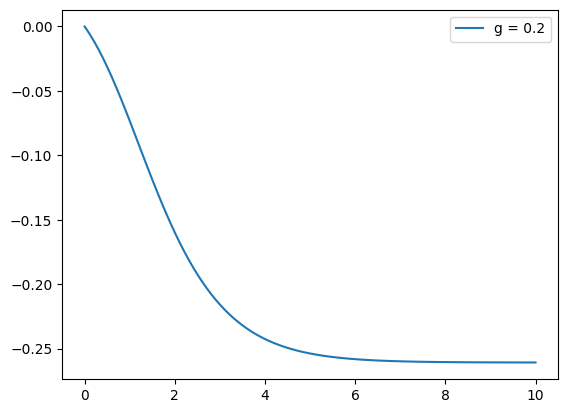

In [ ]:
plt.plot(beta, t_2_max_TF, label=f"g = {g}")
plt.legend()
plt.show()

In [ ]:
np.max(t_0_dB_TF)

np.complex128(-0.012213639410757399+0j)

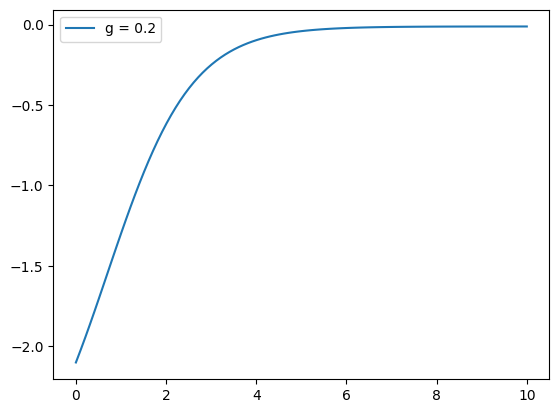

In [ ]:
plt.plot(beta, t_0_dB_TF, label=f"g = {g}")
plt.legend()
plt.show()

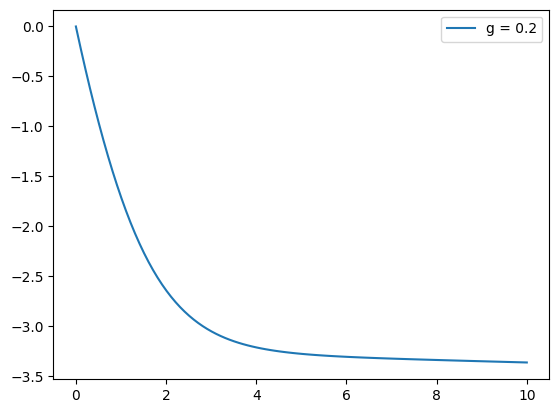

In [ ]:
plt.plot(beta, t_0_sol_TF, label=f"g = {g}")
plt.legend()
plt.show()

In [ ]:
site = 3
state = 5

In [ ]:
si5_st5_sol = []
si5_st5_dB = []
si5_st5_ED_Z = []
si5_st5_ED_U = []
beta_array = []
g_array = np.array([0, 0.1, 0.2, 0.3, 0.5])

K_tilda_new_perm = K_tilda_new[np.ix_(row_permute, col_permute)]

for g_index, g in enumerate(g_array):

    H = hamiltonian_sparse(state, site, g)[0].toarray()

    eig_val_ED, _ = np.linalg.eigh(H)

    K, V = build_V_in_p(state)
    K, V = K.toarray(), V.toarray()

    U, _ = bz.thermofield_change_of_basis(K)

    K_tilda = bz.H_tilde_maker(K)
    # K_tilda = K_tilda[np.ix_(row_permute, col_permute)]
    # K_tilda = bz.depr_H_tilde_maker(K)
    d_pq = np.eye(state)

    V_tensor = V.reshape(state, state, state, state)

    I = np.eye(state)
    V_prim = oe.contract('pqrs,mw,nv->pmqnrwsv', V_tensor, I, I,  optimize='optimal')

    V_grouped = V_prim.reshape(state**2, state**2, state**2, state**2)


    U_t = U.T

    V_tilda = oe.contract('Mi,Wj,ijab,aN,bV->MWNV', U_t, U_t, V_grouped, U, U, optimize='optimal')


    beta, si5_st5_dB_var, si5_st5_sol_var, _  = integration_scheme(site, state, g, t_init=0,t_final=10,nof_points=100000, import_K_V_TF=True, K_import=K_tilda, V_import=V_tilda)

    si5_st5_ED_Z_val = np.array([np.log(Z(eig_val_ED, x)) for x in beta])
    si5_st5_ED_U_val = np.array([U_stat(eig_val_ED, x) for x in beta])

    si5_st5_dB.append(si5_st5_dB_var)
    si5_st5_sol.append(si5_st5_sol_var)
    si5_st5_ED_Z.append(si5_st5_ED_Z_val)
    si5_st5_ED_U.append(si5_st5_ED_U_val)
    beta_array.append(beta)

/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


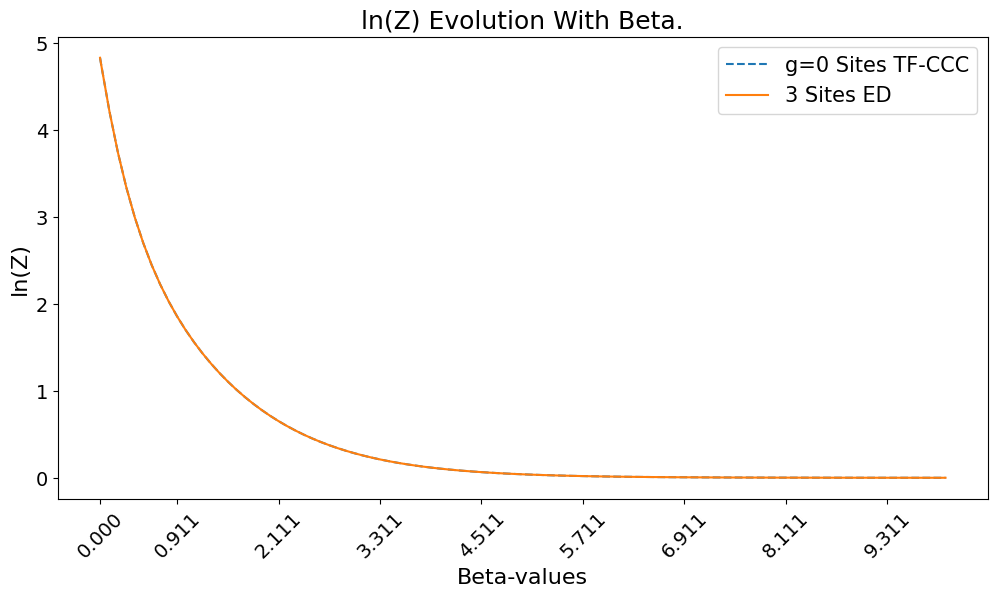

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(beta_array[0], si5_st5_sol[0] + np.log(state**site), label=f"g={0} Sites TF-CCC", linestyle='--')
plt.plot(beta_array[0], si5_st5_ED_Z[0], label=f"{site} Sites ED")
plt.xticks(beta_array[0][::12], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("ln(Z)")
plt.title("ln(Z) Evolution With Beta.", fontsize=18)
plt.legend()
plt.show()

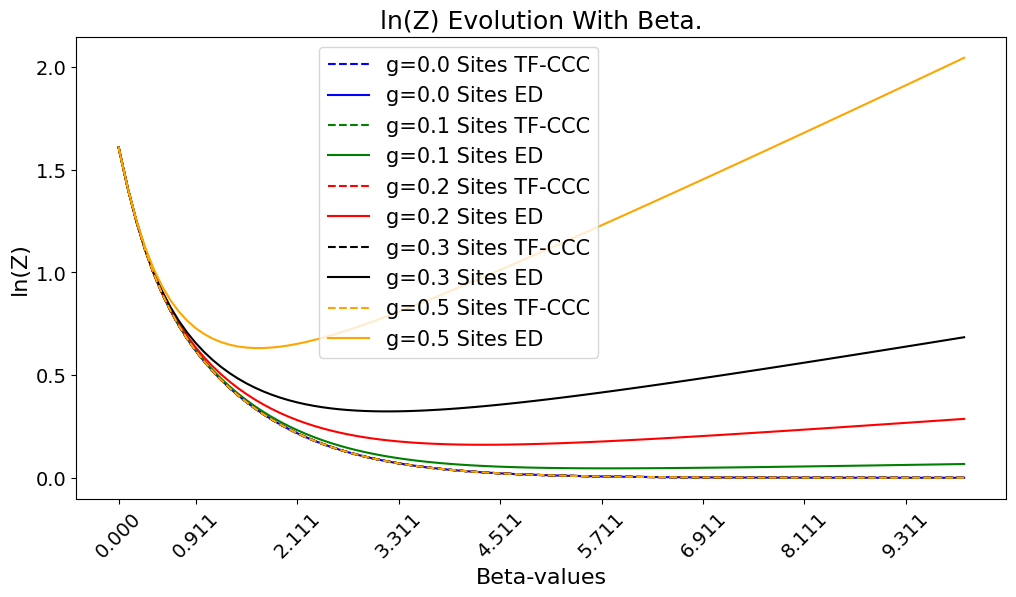

In [ ]:
plt.figure(figsize=(12, 6))
plt.rcParams.update({
    'font.size': 14,              # Larger font for all text
    'legend.fontsize': 15,        # Larger legend text
    'axes.labelsize': 16,         # Axis labels
    'xtick.labelsize': 14,        # Tick labels
    'ytick.labelsize': 14
})

colours = ["blue", "green", "red", "black", "orange"]

for g_index, g in enumerate(g_array):
    plt.plot(beta_array[g_index], (si5_st5_sol[g_index] + np.log(state**site))/site,
              label=f"g={g} Sites TF-CCC", linestyle='--', color = colours[g_index])
    plt.plot(beta_array[g_index], si5_st5_ED_Z[g_index]/site, label=f"g={g} Sites ED",  color = colours[g_index])
plt.xticks(beta_array[g_index][::12], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("ln(Z)")
plt.title("ln(Z) Evolution With Beta.", fontsize=18)
plt.legend(loc='upper left', bbox_to_anchor=(0.25, 1))
plt.show()

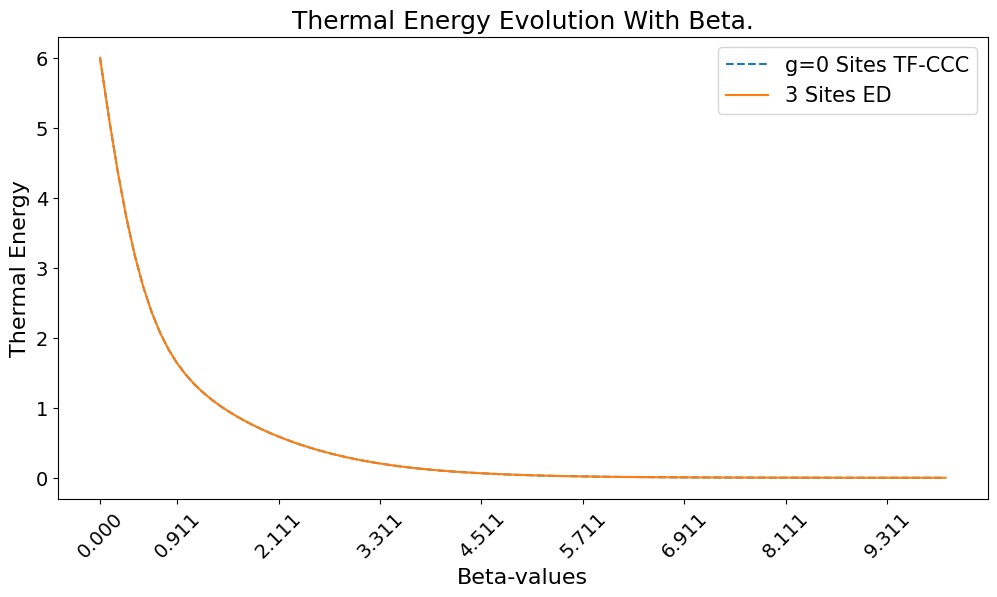

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(beta_array[0], -si5_st5_dB[0], label=f"g={0} Sites TF-CCC", linestyle='--')
plt.plot(beta_array[0], si5_st5_ED_U[0], label=f"{site} Sites ED")
plt.xticks(beta_array[0][::12], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("Thermal Energy")
plt.title("Thermal Energy Evolution With Beta.", fontsize=18)
plt.legend()
plt.show()

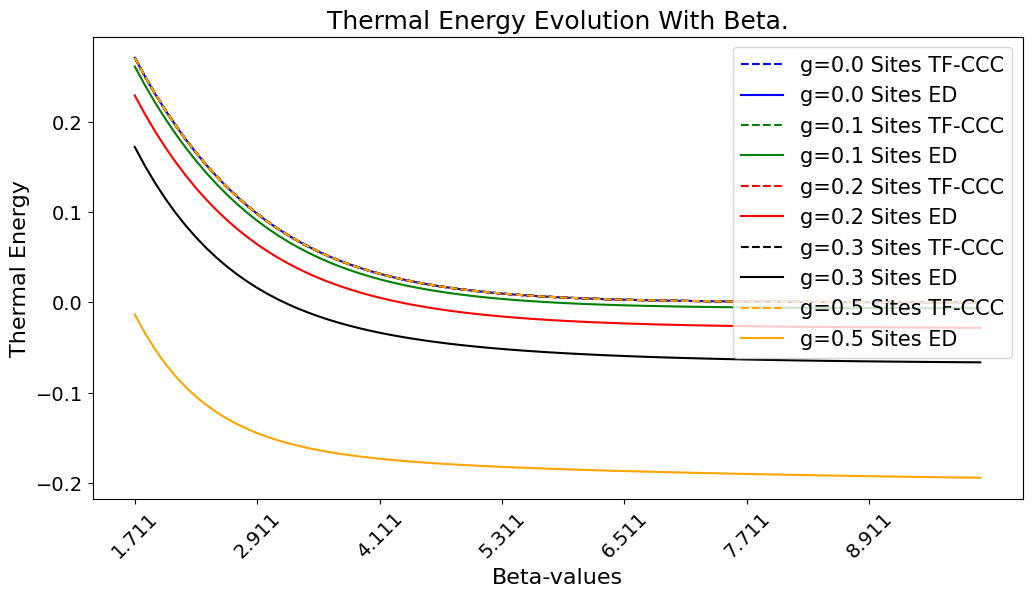

In [ ]:
d = 20

plt.figure(figsize=(12, 6))
plt.rcParams.update({
    'font.size': 14,              # Larger font for all text
    'legend.fontsize': 15,        # Larger legend text
    'axes.labelsize': 16,         # Axis labels
    'xtick.labelsize': 14,        # Tick labels
    'ytick.labelsize': 14
})

for g_index, g in enumerate(g_array):
    plt.plot(beta_array[g_index][d:], -si5_st5_dB[g_index][d:]/site, label=f"g={g} Sites TF-CCC", linestyle='--', color=colours[g_index])
    plt.plot(beta_array[g_index][d:], si5_st5_ED_U[g_index][d:]/site, label=f"g={g} Sites ED",  color=colours[g_index])
plt.xticks(beta_array[g_index][d:][::12], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("Thermal Energy")
plt.title("Thermal Energy Evolution With Beta.", fontsize=18)
plt.legend(loc='upper right')
plt.show()

In [ ]:
si5_st5_ED_A = []
si5_st5_ED_S = []

for g_index, g in enumerate(g_array):

    H = hamiltonian_sparse(state, site, g)[0].toarray()

    eig_val_ED, _ = np.linalg.eigh(H)

    si5_st5_ED_A_val = np.array([A(eig_val_ED, x) for x in beta_array[g_index]])
    si5_st5_ED_S_val = np.array([S(eig_val_ED, x) for x in beta_array[g_index]])

    si5_st5_ED_A.append(si5_st5_ED_A_val)
    si5_st5_ED_S.append(si5_st5_ED_S_val)

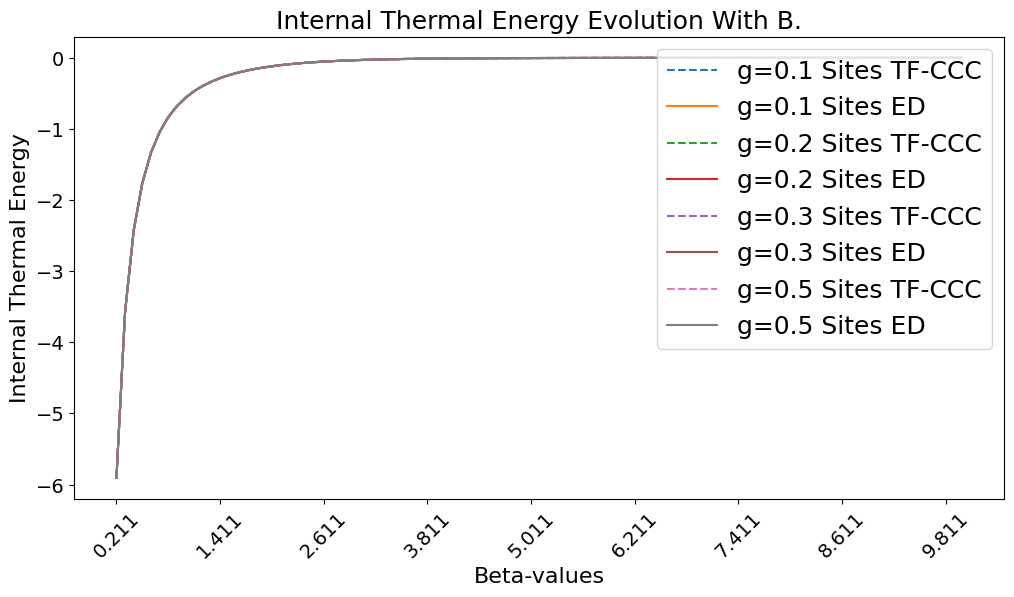

In [ ]:
d = 5

plt.figure(figsize=(12, 6))
plt.rcParams.update({
    'font.size': 14,              # Larger font for all text
    'legend.fontsize': 18,        # Larger legend text
    'axes.labelsize': 16,         # Axis labels
    'xtick.labelsize': 14,        # Tick labels
    'ytick.labelsize': 14
})

for g_index, g in enumerate(g_array[1:]):
    g_index = 0
    plt.plot(beta_array[g_index][d:], (-(beta_array[g_index][d:]**(-1)) * (si5_st5_sol[g_index][d:] + np.log(state**site)))/site,
              label=f"g={g} Sites TF-CCC", linestyle='--')
    plt.plot(beta_array[g_index][d:], si5_st5_ED_A[g_index][d:]/site, label=f"g={g} Sites ED")
plt.xticks(beta_array[g_index][d:][::12], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("Internal Thermal Energy")
plt.title("Internal Thermal Energy Evolution With B.", fontsize=18)
plt.legend(loc='upper right')
plt.show()

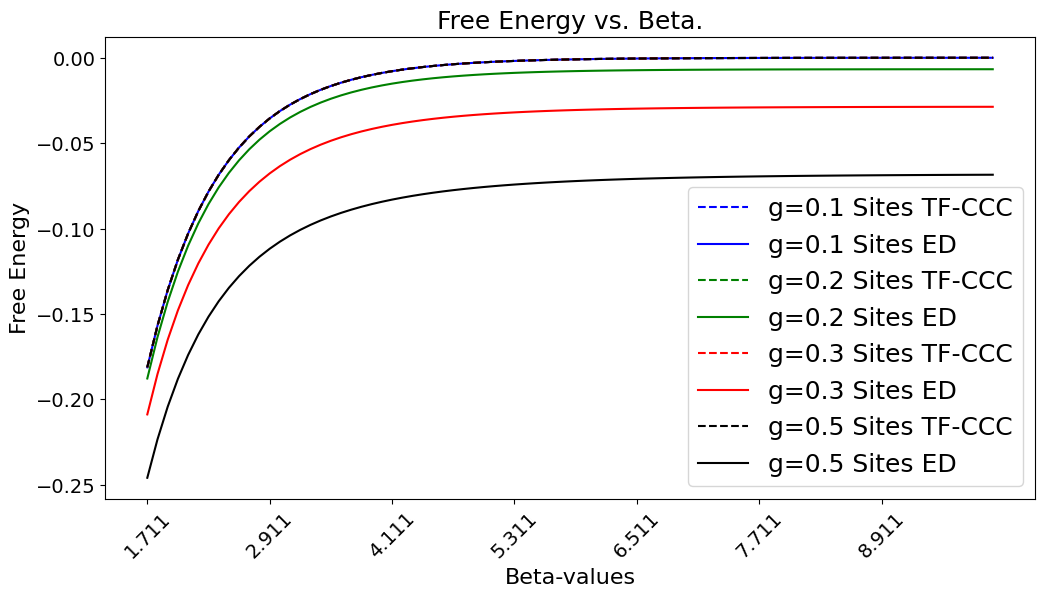

In [ ]:
d = 20

plt.figure(figsize=(12, 6))
plt.rcParams.update({
    'font.size': 14,              # Larger font for all text
    'legend.fontsize': 18,        # Larger legend text
    'axes.labelsize': 16,         # Axis labels
    'xtick.labelsize': 14,        # Tick labels
    'ytick.labelsize': 14
})

for g_index, g in enumerate(g_array[1:]):
    plt.plot(beta_array[g_index][d:], (-(beta_array[g_index][d:]**(-1)) * (si5_st5_sol[g_index][d:] + np.log(state**site)))/site,
              label=f"g={g} Sites TF-CCC", linestyle='--', color=colours[g_index])
    plt.plot(beta_array[g_index][d:], si5_st5_ED_A[g_index][d:]/site, label=f"g={g} Sites ED", color=colours[g_index])
plt.xticks(beta_array[g_index][d:][::12], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("Free Energy")
plt.title("Free Energy vs. Beta.", fontsize=18)
plt.legend(loc='lower right')
plt.show()

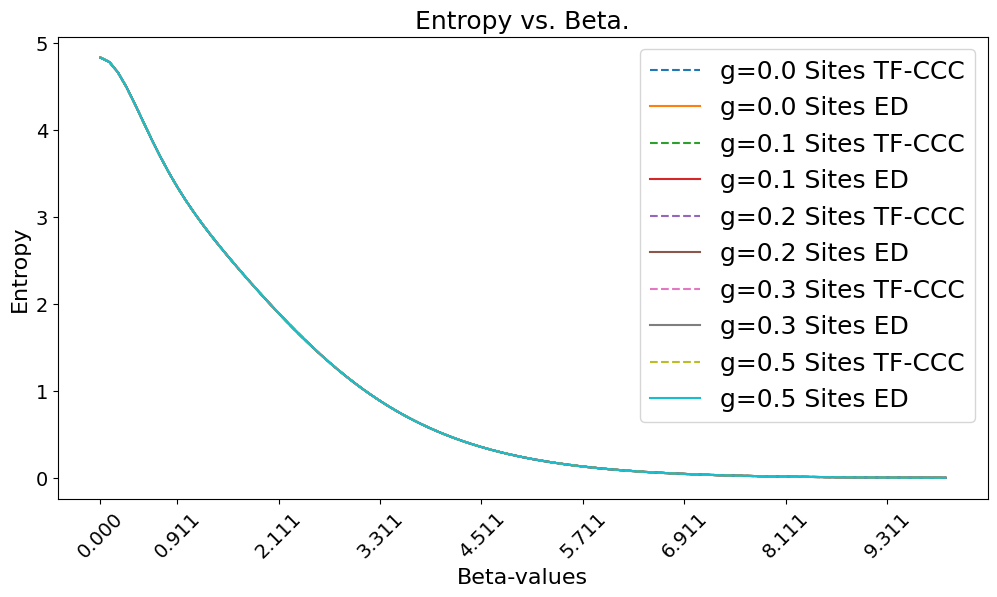

In [ ]:
d = 20

plt.figure(figsize=(12, 6))
plt.rcParams.update({
    'font.size': 14,              # Larger font for all text
    'legend.fontsize': 18,        # Larger legend text
    'axes.labelsize': 16,         # Axis labels
    'xtick.labelsize': 14,        # Tick labels
    'ytick.labelsize': 14
})

for g_index, g in enumerate(g_array):
    g_index = 0
    plt.plot(beta_array[g_index], beta_array[g_index] * -si5_st5_dB[g_index] + (si5_st5_sol[g_index] + np.log(state**site)),
              label=f"g={g} Sites TF-CCC", linestyle='--')
    plt.plot(beta_array[g_index], si5_st5_ED_S[g_index], label=f"g={g} Sites ED")
plt.xticks(beta_array[g_index][::12], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("Entropy")
plt.title("Entropy vs. Beta.", fontsize=18)
plt.legend(loc='upper right')
plt.show()

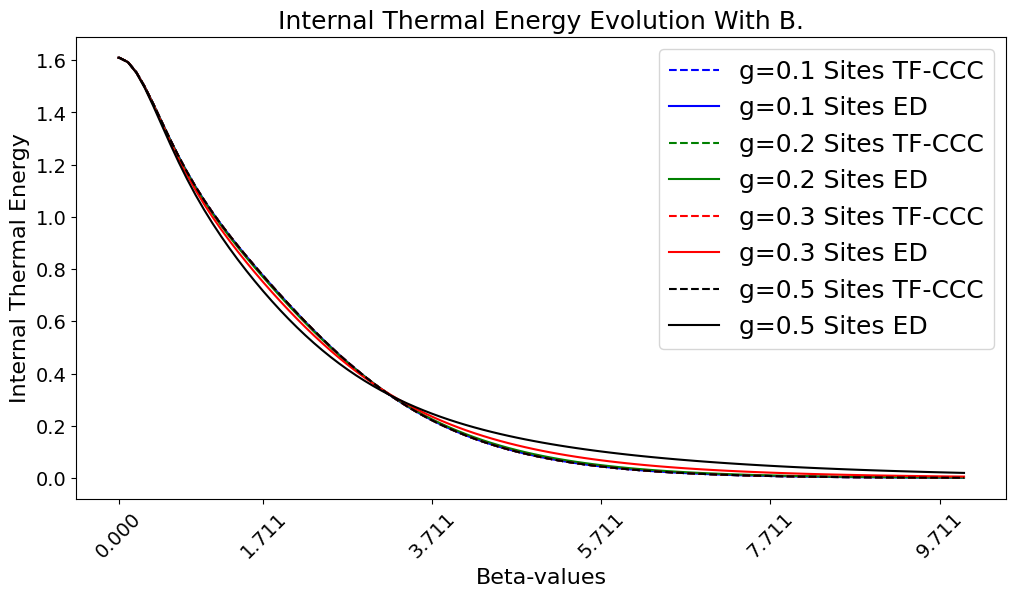

In [ ]:
d = 0

plt.figure(figsize=(12, 6))
plt.rcParams.update({
    'font.size': 14,              # Larger font for all text
    'legend.fontsize': 18,        # Larger legend text
    'axes.labelsize': 16,         # Axis labels
    'xtick.labelsize': 14,        # Tick labels
    'ytick.labelsize': 14
})

for g_index, g in enumerate(g_array[1:]):

    plt.plot(beta_array[g_index][d:], (beta_array[g_index][d:] * -si5_st5_dB[g_index][d:] + (si5_st5_sol[g_index][d:] + np.log(state**site)))/site,
              label=f"g={g} Sites TF-CCC", linestyle='--', color=colours[g_index])
    plt.plot(beta_array[g_index][d:], si5_st5_ED_S[g_index][d:]/site, label=f"g={g} Sites ED", color=colours[g_index])
plt.xticks(beta_array[g_index][d:][::20], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("Internal Thermal Energy")
plt.title("Internal Thermal Energy Evolution With B.", fontsize=18)
plt.legend(loc='upper right')
plt.show()